In [1]:
import torch
from torch import nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import json
from Bio import SeqIO
import gzip
import glob
import numpy as np


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


In [ ]:
data_location = 'Data/Arabidopsis_thaliana.TAIR10.pep.all.fa.gz'

bni = {'a':0, 't':1, 'g':2, 'c':3}
nucleotide_indexes = {'a': bni['a'], 't':bni['t'], 'g':bni['g'], 'c':bni['c'], 'w': (bni['a'],bni['t']), 
                      'n': (bni['a'],bni['t'],bni['g'],bni['c']), 'y': (bni['t'], bni['c']), 's': (bni['g'], bni['c']), 
                      'm': (bni['a'],bni['c']), 'k': (bni['t'],bni['g']), 'r': (bni['a'], bni['g']), 'd': (bni['a'], bni['g'], bni['t'])}
nucleotide_values = {'a':1, 't':1, 'g':1, 'c':1, 'w': 0.5, 'n': 0.25, 'y': 0.5, 's': 0.5, 'm': 0.5, 'k': 0.5, 'r': 0.5, 'd':0.3}


def one_hot_encode(seq):
    oneHotEncode = np.zeros([4,len(seq)])
    for i, n in enumerate(seq):
        oneHotEncode[nucleotide_indexes[n.lower()], i] = nucleotide_values[n.lower()]
    return oneHotEncode

gene_id = []
genes = []
with gzip.open(data_location, "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        try:
            chrm = int(record.description.split(' ')[2].split(':')[2])
            start = int(record.description.split(' ')[2].split(':')[3])
            gene_id.append(record.id)
        except:
            continue

        genome_paths = f"Data/RefGenome/Arabidopsis_thaliana.TAIR10.dna.chromosome.{chrm}.fa.gz"
        with gzip.open(genome_paths, "rt") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                chr_seq = str(record.seq)
                onehotseq = one_hot_encode(chr_seq[start:start+2500])

        genes.append(onehotseq)
        # if len(genes) > 1000:
        #     break

genes = np.array(genes)


In [ ]:
# Filter out inhomogeneous rows in the genes array
genes = [gene for gene in genes if gene.shape == (4, 2500)]

# Convert the filtered list back to a numpy array
genes = np.array(genes)

In [ ]:
np.save('Data/Arabidopsis_thaliana_genes.npy', genes)

In [2]:
genes = np.load('Data/Arabidopsis_thaliana_genes.npy')

In [3]:
from src import DeepCNN, SimpleCNN, DNATranformer
deepcnnDir = os.path.join(os.getcwd(), "Model_DeepCNN_Best")
simplecnnDir = os.path.join(os.getcwd(), "Model_SimpleCNN_Best")
transformerDir = os.path.join(os.getcwd(), "Model_DNATranformer_Best")

def load_model(model_dir, model_class, device):
    model = model_class()
    model = torch.load(os.path.join(model_dir, 'model.pth'), weights_only=False)
    model.to(device)
    return model

DeepCNN = load_model(deepcnnDir, DeepCNN, device)
SimpleCNN = load_model(simplecnnDir, SimpleCNN, device)
Transformer = load_model(transformerDir, DNATranformer, device)





/home/formanj/miniconda3/envs/ImgProc_GPU_env/lib/python3.12/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/formanj/miniconda3/envs/ImgProc_GPU_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
heatmap = np.zeros((3, genes.shape[0], 37))

for i in range(genes.shape[0]):
    gene = genes[i]
    gene = torch.tensor(gene, dtype=torch.float32).to(device)
    gene = gene.unsqueeze(0) # Change shape from (1, 2500, 4) to (1, 4, 2500)
    with torch.no_grad():
        deepcnn_output = torch.exp(DeepCNN(gene))
        simplecnn_output = torch.exp(SimpleCNN(gene))
        transformer_output = torch.exp(Transformer(gene))

    heatmap[0,i,:] = deepcnn_output.cpu().numpy()
    heatmap[1,i,:] = simplecnn_output.cpu().numpy()
    heatmap[2,i,:] = transformer_output.cpu().numpy()


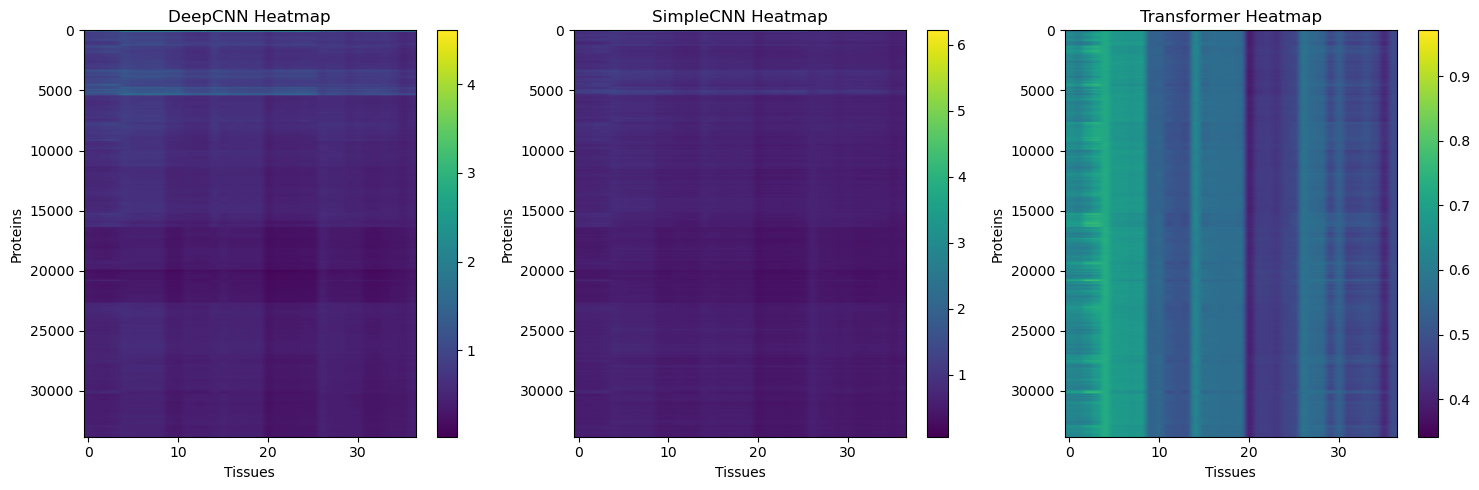

In [5]:
from scipy.cluster.hierarchy import linkage, leaves_list

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

titles = ['DeepCNN Heatmap', 'SimpleCNN Heatmap', 'Transformer Heatmap']

# Perform hierarchical clustering on rows (samples) using the first heatmap
row_linkage_matrix = linkage(heatmap[0], method='ward')
row_sorted_indices = leaves_list(row_linkage_matrix)

# Perform hierarchical clustering on columns (features) using the first heatmap
col_linkage_matrix = linkage(heatmap[0].T, method='ward')
col_sorted_indices = leaves_list(col_linkage_matrix)

for i, ax in enumerate(axes):
    # Reorder heatmap based on clustering from the first heatmap
    sorted_heatmap = heatmap[i][row_sorted_indices][:, col_sorted_indices]
    
    im = ax.imshow(sorted_heatmap, aspect='auto', cmap='viridis')
    ax.set_title(titles[i])
    ax.set_xlabel('Tissues')
    ax.set_ylabel('Proteins')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()